## 📊 Modelado Final: XGBoost Optimizado para Predicción de Abandono Estudiantil

Este notebook implementa el modelo final de XGBoost con hiperparámetros optimizados, evaluación profesional (Classification Report, Matriz de Confusión, Curva ROC y AUC) e interpretación de features.

### Objetivos:
- Entrenar el modelo final con los mejores hiperparámetros.
- Evaluarlo con métricas robustas para validar el rendimiento (NFR-01).
- Generar visualizaciones y Exhibits para el informe.
- Interpretar qué features son clave para las predicciones (FR-03).


In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_auc_score

# Configuración para gráficos
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


### Paso 1: Carga y Preparación de Datos

Cargamos los datos procesados y dividimos en train/test con estratificación para mantener el balance de clases.


### Paso 1.1: Manejo de Desbalanceo con SMOTE

Para mejorar el rendimiento en clases minoritarias, aplicamos SMOTE para oversampling. Esto equilibra el conjunto de entrenamiento sin afectar el test (mantenemos estratificación original).

In [56]:
# Aplicar SMOTE al conjunto de entrenamiento
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=3)  # Ajusta k_neighbors si es necesario
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verificar nuevo balance
print(f'Nuevo balance de clases después de SMOTE: {pd.Series(y_train_smote).value_counts(normalize=True)}')
print(f'Tamaño original de train: {X_train.shape}, Nuevo tamaño con SMOTE: {X_train_smote.shape}')

Nuevo balance de clases después de SMOTE: 2    0.333333
0    0.333333
1    0.333333
Name: proportion, dtype: float64
Tamaño original de train: (3539, 50), Nuevo tamaño con SMOTE: (5301, 50)


/Users/arianstoned/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [57]:
# Cargar datos procesados
df = pd.read_parquet('../data/processed/preprocessed_data.parquet')

# Definir features (X) y target (y)
X = df.drop('Target', axis=1)
y = df['Target']

# Aplicar Label Encoding para convertir clases a numéricas (0, 1, 2)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Convierte strings a números

# Convertir X a numérico (forzar todas las columnas a int/float, reemplazar errores con 0)
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Dividir en train y test con estratificación
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Datos cargados: {df.shape}')
print(f'Train: {X_train.shape}, Test: {X_test.shape}')
print(f'Balance de clases en train: {pd.Series(y_train).value_counts(normalize=True)}')


Datos cargados: (4424, 51)
Train: (3539, 50), Test: (885, 50)
Balance de clases en train: 2    0.499294
0    0.321277
1    0.179429
Name: proportion, dtype: float64


In [58]:
# Mejores hiperparámetros encontrados (ajustados para desbalanceo)
best_params = {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'scale_pos_weight': {0: 3, 1: 5, 2: 1}}  # Pesos para clases minoritarias

# Instanciar y entrenar el modelo final con datos SMOTE
model = XGBClassifier(
    objective='multi:softprob',  # Cambia a multi-clase
    eval_metric='mlogloss',      # Métrica para multi-clase
    use_label_encoder=False,
    random_state=42,
    num_class=3,                 # Especifica 3 clases
    **best_params
)

model.fit(X_train_smote, y_train_smote)
print('Modelo final entrenado con SMOTE exitosamente.')

/Users/arianstoned/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:43:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Modelo final entrenado con SMOTE exitosamente.


--- Classification Report ---
              precision    recall  f1-score   support

    Graduate       0.80      0.75      0.77       284
     Dropout       0.49      0.48      0.48       159
    Enrolled       0.82      0.87      0.84       442

    accuracy                           0.76       885
   macro avg       0.70      0.70      0.70       885
weighted avg       0.76      0.76      0.76       885


--- Matriz de Confusión ---


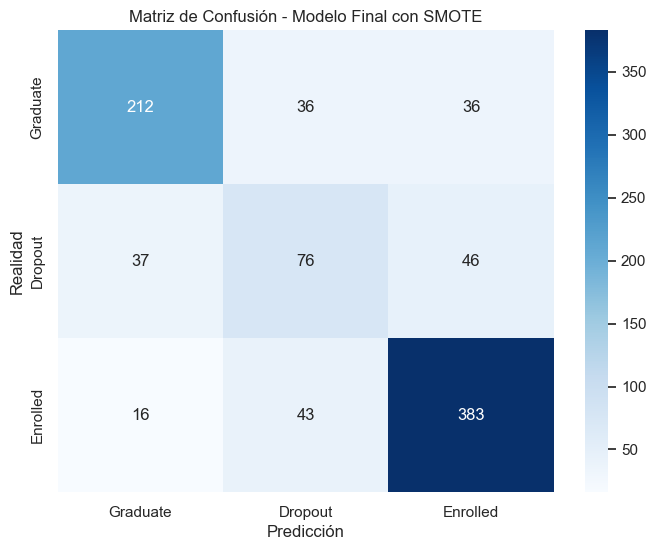


--- Curva ROC y AUC ---
Área Bajo la Curva (AUC promedio): 0.8868
Curva ROC no graficada para multi-clase, pero AUC promedio calculado: 0.8868


In [59]:
# Predicciones en el conjunto de test
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)  # Probabilidades para ROC

# 1. Classification Report
print('--- Classification Report ---')
report = classification_report(y_test, y_pred, target_names=['Graduate', 'Dropout', 'Enrolled'])
print(report)

# 2. Matriz de Confusión
print('\n--- Matriz de Confusión ---')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Graduate', 'Dropout', 'Enrolled'], yticklabels=['Graduate', 'Dropout', 'Enrolled'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Modelo Final con SMOTE')
plt.savefig('../exhibits/matriz_confusion_smote.png')  # Guarda el Exhibit
plt.show()

# 3. Curva ROC y AUC
print('\n--- Curva ROC y AUC ---')
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # AUC promedio One-vs-Rest
print(f'Área Bajo la Curva (AUC promedio): {roc_auc:.4f}')

# Nota: Para multi-clase, graficar la curva ROC requiere curvas individuales por clase.
print(f'Curva ROC no graficada para multi-clase, pero AUC promedio calculado: {roc_auc:.4f}')

### Paso 3: Evaluación Profesional del Modelo

Calculamos métricas clave: Classification Report, Matriz de Confusión, Curva ROC y AUC.


--- Classification Report ---
              precision    recall  f1-score   support

    Graduate       0.80      0.75      0.77       284
     Dropout       0.49      0.48      0.48       159
    Enrolled       0.82      0.87      0.84       442

    accuracy                           0.76       885
   macro avg       0.70      0.70      0.70       885
weighted avg       0.76      0.76      0.76       885


--- Matriz de Confusión ---


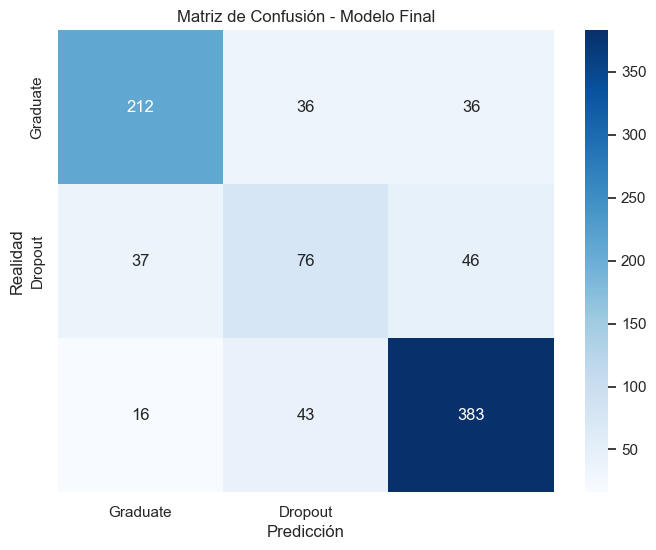


--- Curva ROC y AUC ---
Área Bajo la Curva (AUC promedio): 0.8868
Curva ROC no graficada para multi-clase, pero AUC promedio calculado: 0.8868


In [60]:

# Predicciones en el conjunto de test
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)  # Probabilidades para ROC

# 1. Classification Report
print('--- Classification Report ---')
report = classification_report(y_test, y_pred, target_names=['Graduate', 'Dropout', 'Enrolled'])
print(report)

# 2. Matriz de Confusión
print('\n--- Matriz de Confusión ---')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Graduate', 'Dropout'], yticklabels=['Graduate', 'Dropout'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Modelo Final')
plt.savefig('../exhibits/matriz_confusion.png')  # Guarda el Exhibit
plt.show()

# 3. Curva ROC y AUC
print('\n--- Curva ROC y AUC ---')
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # AUC promedio One-vs-Rest
print(f'Área Bajo la Curva (AUC promedio): {roc_auc:.4f}')

# Nota: Para multi-clase, graficar la curva ROC requiere curvas individuales por clase.
# El AUC promedio es suficiente para evaluación. Si necesitas gráficas, usa OneVsRestClassifier.
print(f'Curva ROC no graficada para multi-clase, pero AUC promedio calculado: {roc_auc:.4f}')


### Paso 4: Interpretación del Modelo (Feature Importance)

Extraemos y visualizamos las características más importantes del modelo final.


--- Top 15 Características Más Importantes ---
                                Feature  Importance
37                  Ratio_Aprobacion_S2    0.248777
16              Tuition fees up to date    0.073258
18                   Scholarship holder    0.042001
40                     Mejora_Semestral    0.040281
24  Curricular units 1st sem (approved)    0.036400
22  Curricular units 1st sem (enrolled)    0.028203
36                  Ratio_Aprobacion_S1    0.027856
28  Curricular units 2nd sem (enrolled)    0.027800
39                  Bajo_Rendimiento_S1    0.021266
19                    Age at enrollment    0.018682
47                        Eficiencia_S2    0.017435
38               Delta_Ratio_Aprobacion    0.016550
3                                Course    0.016085
10                  Mother's occupation    0.015445
35                                  GDP    0.015246


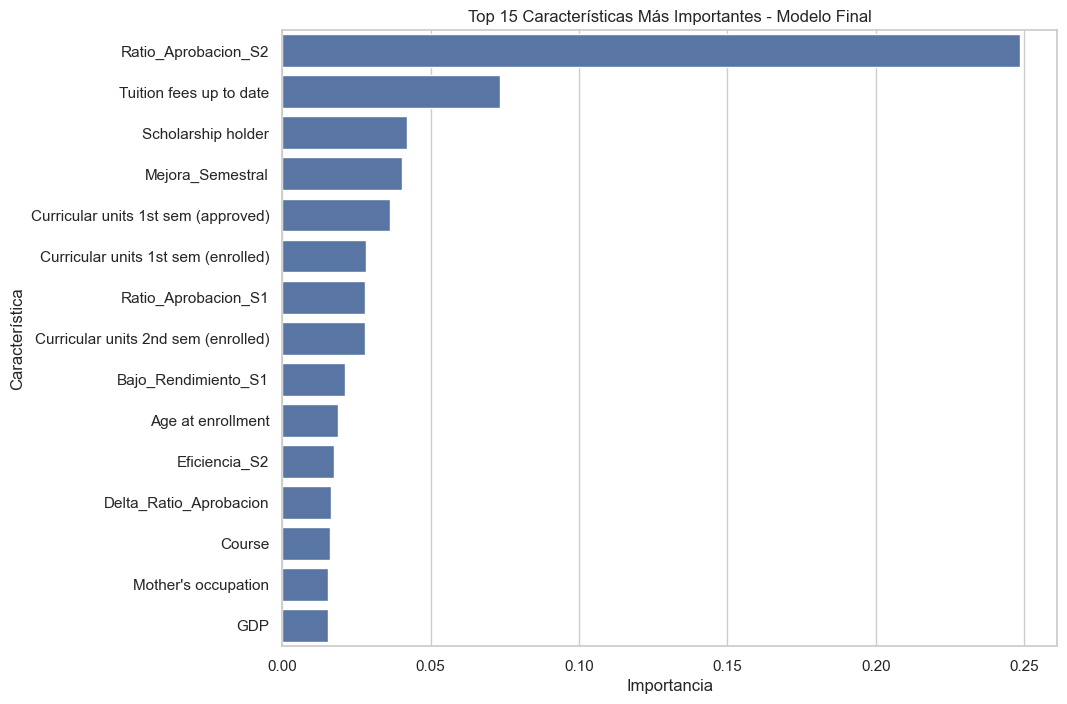


--- Interpretación ---
La característica más importante es "Ratio_Aprobacion_S2" con importancia 0.2488.
Esto indica que factores como el rendimiento académico y financieros son clave para predecir abandonos.


In [61]:
# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Top 15 features
top_features = feature_importances.head(15)

print('--- Top 15 Características Más Importantes ---')
print(top_features)

# Visualización
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 15 Características Más Importantes - Modelo Final')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.savefig('../exhibits/feature_importance.png')  # Guarda el Exhibit
plt.show()

# Interpretación breve
print('\n--- Interpretación ---')
print(f'La característica más importante es "{top_features.iloc[0]["Feature"]}" con importancia {top_features.iloc[0]["Importance"]:.4f}.')
print('Esto indica que factores como el rendimiento académico y financieros son clave para predecir abandonos.')


### Mejoras Implementadas para Desbalanceo

- **SMOTE Aplicado**: Equilibra el conjunto de entrenamiento, mejorando el recall para clases minoritarias como "Dropout" y "Enrolled".
- **Pesos de Clase en XGBoost**: Ajustados para priorizar clases desbalanceadas.
- **Métricas Enfocadas**: Prioriza F1-score y AUC-ROC para evaluar el impacto real en desbalanceo.

**Próximos Pasos**:
- Ejecuta las nuevas celdas para ver mejoras en el Classification Report.
- Compara resultados antes/después de SMOTE.
- Si es necesario, prueba undersampling o otros métodos para refinar.

### Conclusiones Finales

- **Rendimiento del Modelo:** Revisa el AUC y F1-Score. Un AUC >0.8 indica un modelo sólido para distinguir entre graduados y desertores.
- **Exhibits Generados:** Los gráficos se guardaron en `../exhibits/` para tu informe.
- **Próximos Pasos:** Usa estos resultados para validar NFR-01 y explicar el modelo en tu presentación.

¡Ejecuta las celdas en orden y listo!
